In [1]:
import cv2
import numpy as np
from utils import show_images
src = cv2.imread('./image/text/scenetext03.jpg', -1)

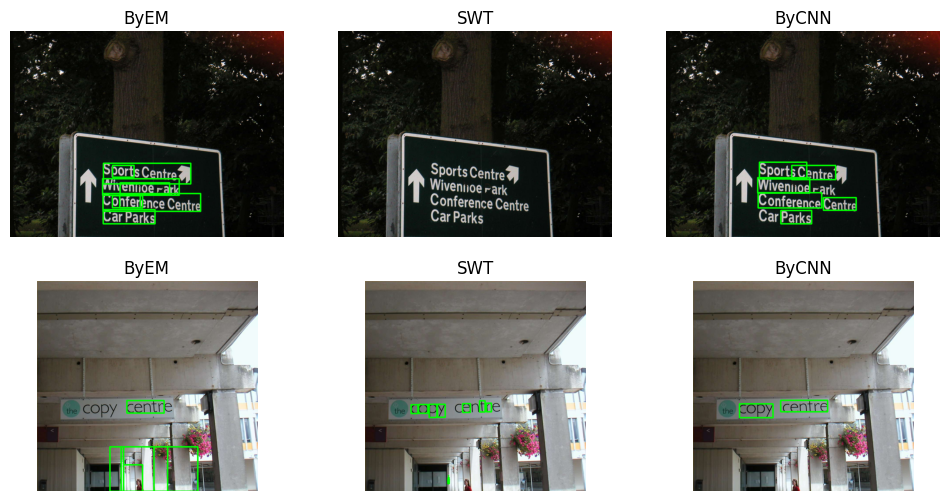

In [5]:
'''
文字识别
'''
######################################   EM  ############################################
def EM(src):
    channels = cv2.text.computeNMChannels(src)
    # 这一步的意义：Append negative channels to detect ER- (bright regions over dark background)
    channels = list(channels) + list([255-x for x in channels])

    er_filter1 = cv2.text.createERFilterNM1(cv2.text.loadClassifierNM1('./image/text/trained_classifierNM1.xml'), 16, 0.00015, 0.13, 0.2, True, 0.1)
    er_filter2 = cv2.text.createERFilterNM2(cv2.text.loadClassifierNM2('./image/text/trained_classifierNM2.xml'), 0.5)

    nowimg = np.copy(src)
    for idx, channel in enumerate(channels):
        # CPP 可以进行如下等价操作，Python 不支持 
        # er_filter1->run(channel, region);   er_filter2->run(channel, region);
        regions = cv2.text.detectRegions(channel, er_filter1, er_filter2)
        rects = cv2.text.erGrouping(src, channel, [r.tolist() for r in regions])

        for rect in rects:
            cv2.rectangle(nowimg, (rect[0], rect[1]), (rect[0]+rect[2], rect[1]+rect[3]), color=(0, 255, 0), thickness=5)
    return nowimg

######################################   SWT  ############################################
def SWT(src):
    nowimg = np.copy(src)
    rects, _, _ = cv2.text.detectTextSWT(src, dark_on_light=True)
    for rect in rects:
        cv2.rectangle(nowimg, (rect[0], rect[1]), (rect[0]+rect[2], rect[1]+rect[3]), color=(0, 255, 0), thickness=5)
    return nowimg

######################################   CNN  ############################################
def CNN(src):
    # 重要：需要先安装 TextBoxes_icdar13.caffemodel
    # https://github.com/PacktPublishing/OpenCV-3-Computer-Vision-with-Python-Cookbook/blob/master/data/TextBoxes_icdar13.caffemodel
    textSpotter = cv2.text.TextDetectorCNN_create("./image/text/textbox.prototxt", "./image/text/TextBoxes_icdar13.caffemodel")
    rects, outProbs = textSpotter.detect(src)

    nowimg = np.copy(src)
    for rect, outProb in zip(rects, outProbs):
        if outProb > 0.5:
            cv2.rectangle(nowimg, (rect[0], rect[1]), (rect[0]+rect[2], rect[1]+rect[3]), color=(0, 255, 0), thickness=5)
    return nowimg

result = []
for i in range(2, 4):
    src = cv2.imread(f'./image/text/scenetext0{i}.jpg', -1)
    result.extend([['ByEM', EM(src)], ['SWT', SWT(src)], ['ByCNN', CNN(src)]])

show_images(result, colnum=3)

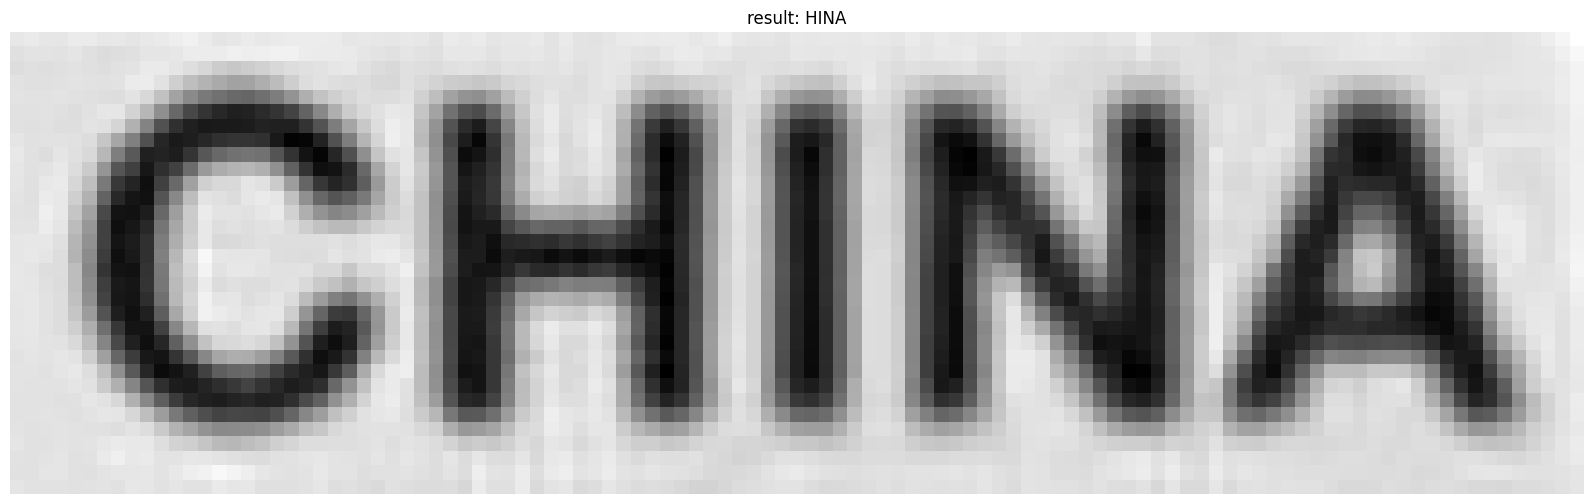

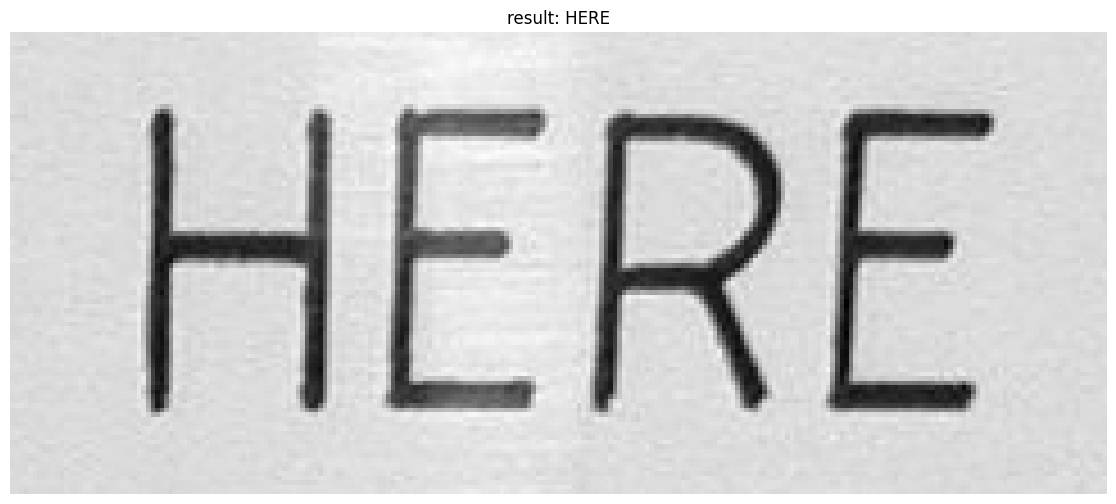

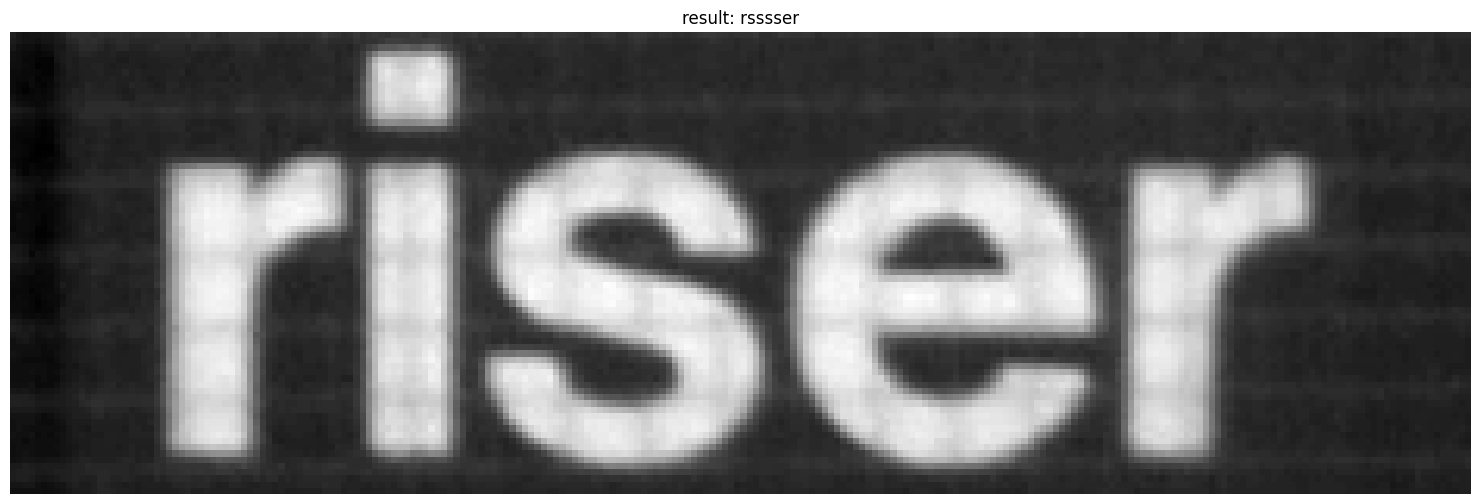

In [5]:
'''
文字检测：OCRBeamSearchDecoder
'''
chartables = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"

classifier = cv2.text.loadOCRBeamSearchClassifierCNN('./image/text/OCRBeamSearch_CNN_model_data.xml.gz')

# 默认的文件: (created from ispell 42869 English words list)
fs = cv2.FileStorage('./image/text/OCRHMM_transitions_table.xml',cv2.FILE_STORAGE_READ)
transition_p = fs.getNode('transition_probabilities').mat()

emission_p = np.eye(len(chartables), len(chartables)).astype(float)

# 要求 transition 和 emission 必须和 vocabulary 一样大小
assert(transition_p.shape[0] == transition_p.shape[1] == len(chartables))
decoder = cv2.text.OCRBeamSearchDecoder.create(
    classifier, 
    vocabulary=chartables, 
    transition_probabilities_table=transition_p,
    emission_probabilities_table=emission_p
)

for i in range(1, 3):
    src = cv2.imread(f'./image/text/scenetext_word0{i}.jpg', -1)
    src = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    text = decoder.run(src, min_confidence=0)
    show_images([(f'result: {text}', src)])

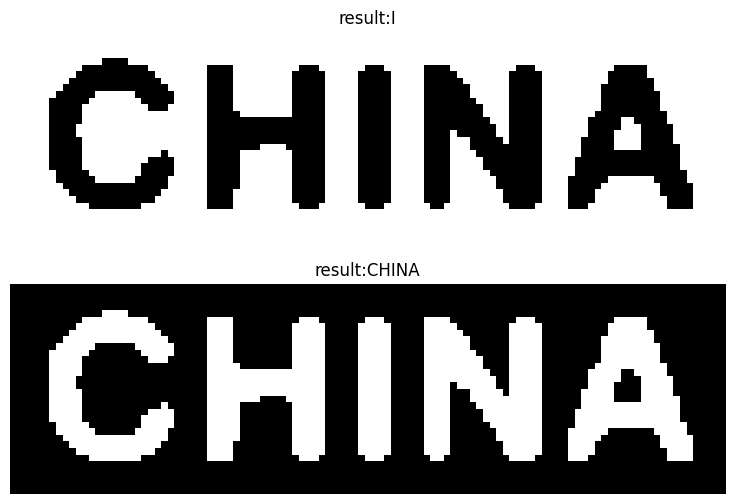

In [2]:
'''
文字检测
segmented_word_recognition.cpp
'''
chartables = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"

# 默认的文件: (created from ispell 42869 English words list)
fs = cv2.FileStorage('./image/text/OCRHMM_transitions_table.xml',cv2.FILE_STORAGE_READ)
transition_p = fs.getNode('transition_probabilities').mat()

# 要求 transition 和 emission 必须和 vocabulary 一样大小
assert(transition_p.shape[0] == transition_p.shape[1] == len(chartables))

emission_p = np.eye(len(chartables), len(chartables)).astype(float)

# 都可以，反正根据第二个参数，来选择第一个参数的文件
classifier = cv2.text.loadOCRHMMClassifier(
    './image/text/OCRHMM_knn_model_data.xml.gz', cv2.text.OCR_KNN_CLASSIFIER)
classifier = cv2.text.loadOCRHMMClassifier(
    './image/text/OCRBeamSearch_CNN_model_data.xml.gz', cv2.text.OCR_CNN_CLASSIFIER)

decoder = cv2.text.OCRHMMDecoder.create(
    classifier = classifier,
    vocabulary=chartables, 
    transition_probabilities_table=transition_p,
    emission_probabilities_table=emission_p
)

# 测试图片一
src = cv2.imread(f'./image/text/scenetext_word01.jpg', -1)
gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

# 需要的是二值图像，并且是黑底白字
thresh1 = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)[1]
result1 = decoder.run(thresh1, min_confidence=0)
thresh2 = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)[1]
result2 = decoder.run(thresh2, min_confidence=0)

# # 测试图片二
# gray = cv2.imread(f'./image/text/small_word.png', -1)
# gray = cv2.resize(gray, (gray.shape[1]*8, gray.shape[0]*8), interpolation=cv2.INTER_CUBIC)

# thresh3 = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)[1]
# result3 = decoder.run(thresh3, min_confidence=0)
# thresh4 = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)[1]
# result4 = decoder.run(thresh4, min_confidence=0)

show_images([
    (f'result:{result1}', thresh1),
    (f'result:{result2}', thresh2),
    # (f'result:{result3}', thresh3),
    # (f'result:{result4}', thresh4),
], colnum=1)

small_image result
tesseract 5:35.82(no config), 35.82(has config)
tesseract 3:38.00(no config), 38.00(has config)


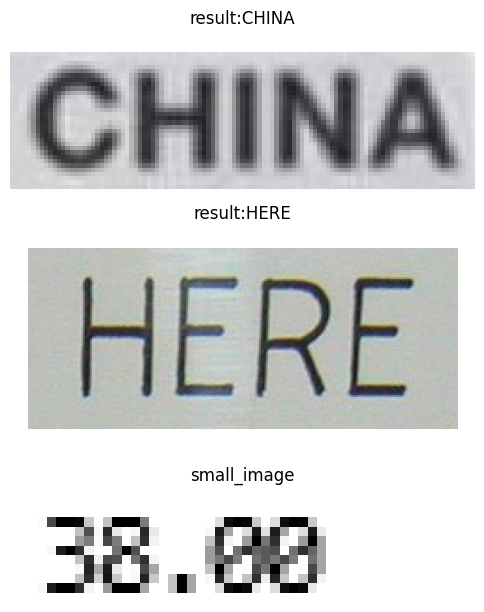

In [13]:
'''
文字检测(Tesseract)
'''
import pytesseract
from PIL import Image

# pytesseract 最好处理一下图片，让图片大一些
def adjust_img(img):
    gray = np.copy(img) if len(img.shape)==2 else cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ratio = 300 // gray.shape[0]
    new_size = (gray.shape[1]*ratio, gray.shape[0]*ratio)

    gray = Image.fromarray(gray)
    gray = gray.resize(new_size, Image.Resampling.LANCZOS)
    return gray

# 需要安装 tesseract v5，然后修改对应目录
pytesseract_dir = 'C:\\Program Files\\Tesseract-OCR'
pytesseract.pytesseract.tesseract_cmd = f'{pytesseract_dir}\\tesseract.exe'

# 测试图片一和二
src1 = cv2.imread(f'./image/text/scenetext_word01.jpg', -1)
text1 = pytesseract.image_to_string(adjust_img(src1))
src2 = cv2.imread(f'./image/text/scenetext_word02.jpg', -1)
text2 = pytesseract.image_to_string(adjust_img(src2))

# 测试图片（数字）
src3 = cv2.imread(f'./image/text/small_word.png', -1)
text3 = pytesseract.image_to_string(adjust_img(src3))
# 增加配置，强行只识别为数字，这个需要具体要看文件夹里有没有这个 digits 文件
text4 = pytesseract.image_to_string(adjust_img(src3), config=f'--psm 6 {pytesseract_dir}\\tessdata\\config\\digits')

# 有的时候 tesseract v5 反而不如 v3，不知道为啥
pytesseract_dir = 'C:\\Program Files\\Tesseract-3'
pytesseract.pytesseract.tesseract_cmd = f'{pytesseract_dir}\\tesseract.exe'
text5 = pytesseract.image_to_string(adjust_img(src3))
text6 = pytesseract.image_to_string(adjust_img(src3), config=f'-psm 6 {pytesseract_dir}\\digits')

print('small_image result')
print(f'tesseract 5:{text3.strip()}(no config), {text4.strip()}(has config)')
print(f'tesseract 3:{text5.strip()}(no config), {text6.strip()}(has config)')
show_images([
    (f'result:{text1}', src1),
    (f'result:{text2}', src2),
    (f'small_image\n', src3),
], colnum=1)